There are two disease in potato; Early Blight and Late Blight.

We need to identify the disease by capturing photo.

collect the data -> Data cleaning and preprocessing (use tf dataset and also do data augmentation) -> Model Building (CNN) -> Export the model --> use MLOPs(use tf serving)--> FastAPI

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32 
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

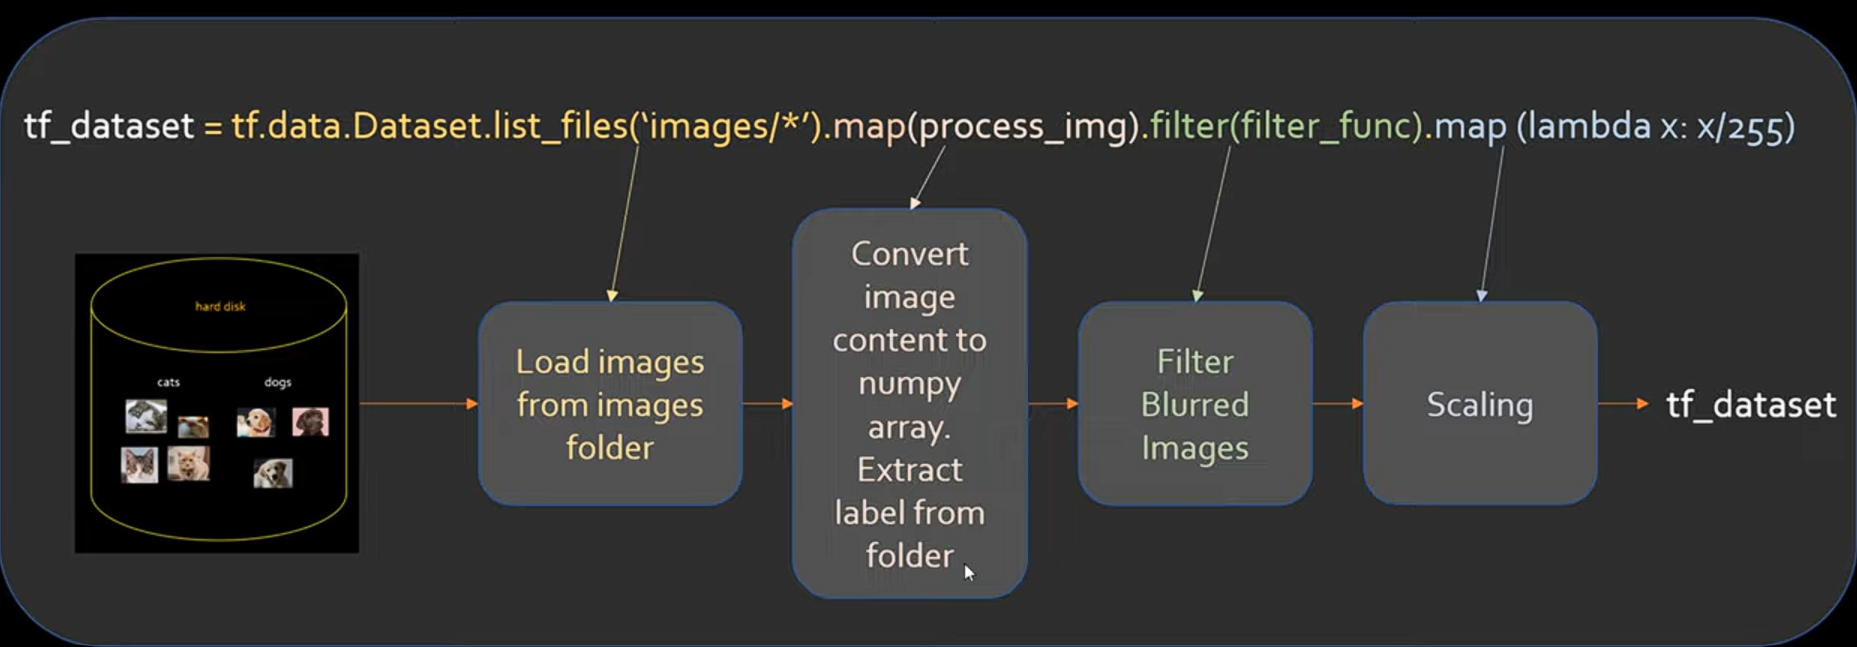

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1): # it take 1 batch that is 32 data
    print(image_batch.shape) #(total_image, width of image, height of image, color channel)
    print(labels_batch.numpy()) # image labels class

(32, 256, 256, 3)
[0 1 0 0 2 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 0]


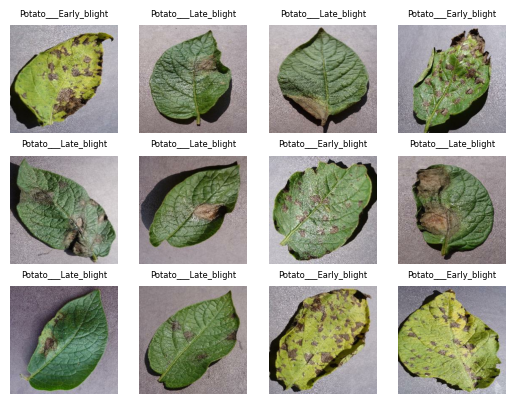

In [6]:
for image_batch, labels_batch in dataset.take(1): # it take 1 batch that is 32 data
    for i in range(12): #only 12 image is printed
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # tensor i is convert to numpy. it is in float to int
        plt.title(class_names[labels_batch[i]], fontsize=6)
        plt.axis("off")
    

Taking 80% training, 10% validation and 10% test

#### train_size =0.8
len(dataset)*train_size

In [7]:
train_ds=dataset.take(54) # take 54 batch of data for training
len(train_ds)

54

In [8]:
test_ds =dataset.skip(54) # take rest data [54:]
len(test_ds)

14

In [9]:
val_size = 0.1
print(len(dataset)*val_size)
val_ds=test_ds.take(6)  # take 6 for 10% 

6.800000000000001


In [10]:
test_dss=test_ds.skip(6)

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # assertdebugging to check if a condition is True. If the condition is False, it raises an AssertionError
    assert(train_split+test_split+val_split)==1

    ds_size = len(ds)
    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12) # seed same shuffle data each time  
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

54

In [14]:
len(val_ds)

6

In [15]:
len(test_ds)

8

In [16]:
#prefetch increase performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # resizing to 256*256
    layers.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [19]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3), activation ='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64,kernel_size=(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    #flatten
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax') #softmax for multiple class. if binary then sigmoid
])

C:\Users\avith\anaconda3\envs\python-3-10\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 942ms/step - accuracy: 0.5209 - loss: 0.9264 - val_accuracy: 0.5625 - val_loss: 0.8331
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 799ms/step - accuracy: 0.6434 - loss: 0.8187 - val_accuracy: 0.8125 - val_loss: 0.5126
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 816ms/step - accuracy: 0.7337 - loss: 0.6400 - val_accuracy: 0.8490 - val_loss: 0.3930
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 804ms/step - accuracy: 0.7810 - loss: 0.5266 - val_accuracy: 0.8229 - val_loss: 0.4843
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 818ms/step - accuracy: 0.7961 - loss: 0.5089 - val_accuracy: 0.8021 - val_loss: 0.5092
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 921ms/step - accuracy: 0.8462 - loss: 0.3710 - val_accuracy: 0.8750 - val_loss: 0.3275
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 808ms/step - accuracy: 0.8828 - loss: 0.2845 - val_accuracy: 0.7604 - val_loss: 0.5798
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 806ms/step - accuracy: 0.9019 - loss: 0.2566 - val_accu

In [24]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8945 - loss: 0.2533


In [25]:
scores

[0.23660872876644135, 0.90625]

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [27]:
history.history['accuracy']

[0.5034722089767456,
 0.6811342835426331,
 0.7528935074806213,
 0.8009259104728699,
 0.8078703880310059,
 0.8547453880310059,
 0.8842592835426331,
 0.9108796119689941,
 0.9178240895271301,
 0.8929398059844971]

In [28]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

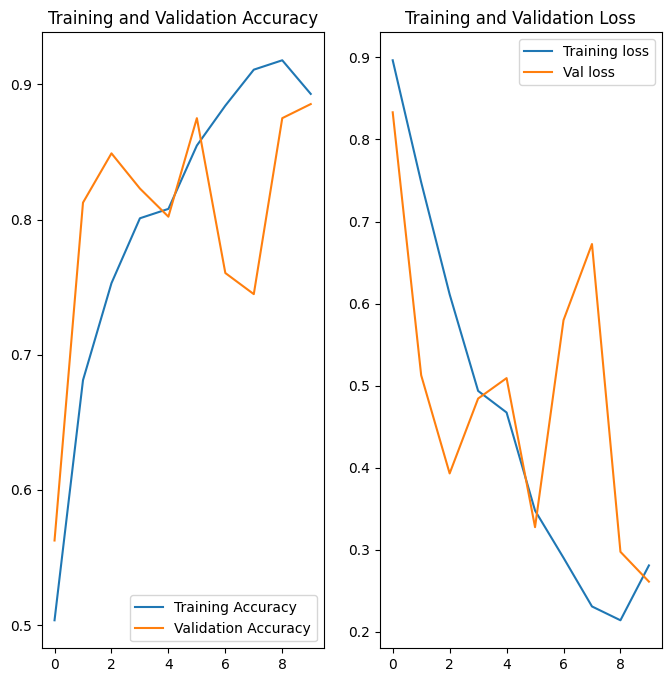

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(10), loss, label='Training loss')
plt.plot(range(10), val_loss, label='Val loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual Label: Potato___Early_blight 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Predicted Label: Potato___Early_blight 0


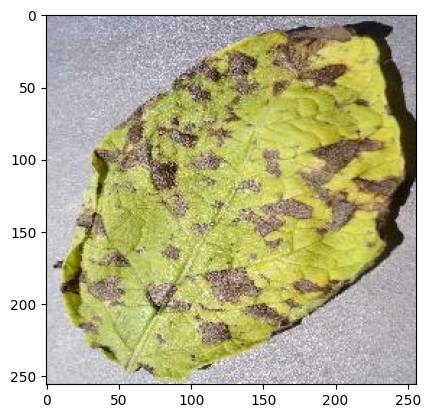

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label:", class_names[labels_batch[0].numpy()], labels_batch[0].numpy())
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])], np.argmax(batch_prediction[0]))

In [36]:
def predict(model, img):
    # image to array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


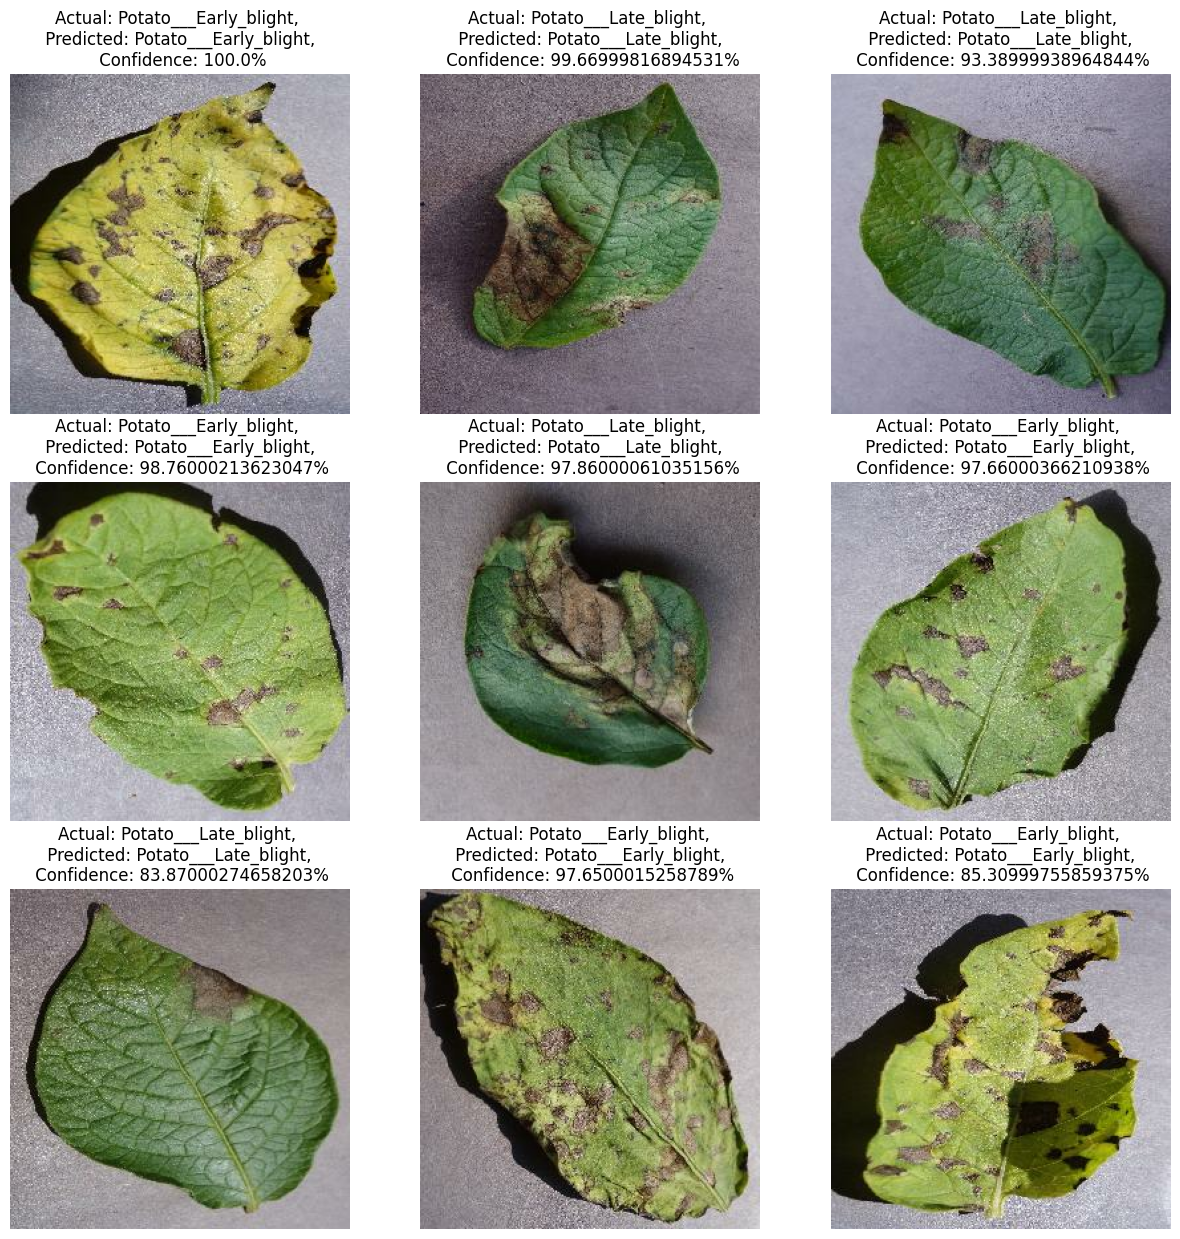

In [41]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [45]:
model_version=1
model.save(f"./{model_version}.keras")